A notebook to analyze results of energy_py experiments

In [1]:
import os

import pandas as pd

from energy_py import make_panel_fig

In [2]:
class Results(object):
    def __init__(self, expt_name, agent_name):
        self.expt_name = expt_name
        self.agent_name = agent_name
        
        self.data = self.load_data()
        self.args = self.load_args()
        
        self.stats = self.make_stats()
        
    def load_data(self):
        base = os.path.join('/Users/adam/git/energy_py/energy_py/experiments', 
                            self.expt_name, self.agent_name, 'csvs')
        
        csvs = ['df_ep.csv', 'df_stp.csv' , 'env_info.csv']
        
        data = {name: pd.read_csv(base + '/' + name, index_col=0, parse_dates=True) 
                for name in csvs}
        
        return data
    
    def load_args(self):
        args_path = os.path.join('/Users/adam/git/energy_py/energy_py/experiments', 
                            self.expt_name, self.agent_name, 'args.txt')
        
        args = {}
        with open(args_path) as f:
            for line in f:
                k,v = line.split(',')
                v = v.rstrip()
                args[k] = v
        return args
    
    def make_stats(self):
        eps = self.data['df_ep.csv']
        steps = self.data['df_stp.csv']
        
        self.avg_rew_stp = steps.loc[:, 'reward'].mean()
        
        #  assuming a 5 min step time
        self.avg_annual_rew = self.avg_rew_stp * (12 * 24 * 365)
        
        self.ep_total_rew = eps.loc[:, 'reward'].values
        
        self.action_count = int(steps.loc[:, 'act_0'].sum())
        
        stats = {'average reward per step': self.avg_rew_stp,
                 'annual avg reward': self.avg_annual_rew,
                 'episode rewards': self.ep_total_rew,
                 'flex actions': self.action_count}
        
        return stats
    

    
    def __repr__(self):
        return 'results_obj_{}'.format(self.agent_name)
    

In [3]:
import pprint

pp = pprint.PrettyPrinter()

class Experiment(object):
    def __init__(self, expt_name, agents):
        self.results = [Results(expt_name, agent) for agent in agents]
        self.check_results()
        
    def check_results(self):
        #  check that the episode lengths were the same by checking the 
        #  length of the last episode
        all(x==self.results[0].data['env_info.csv'].shape[0]
            for x in self.results)
        
    def output_results(self, print_args=False):
        
        for result in self.results:
            print(repr(result))
            if print_args:  pp.pprint(result.args)
            pp.pprint(result.stats)
            
    def make_daily_rew(self):
        daily_rew = pd.DataFrame()
        
        for result in self.results:
            env = result.data['env_info.csv']
            daily_rew[repr(result)] = env['reward'].groupby([env.index.month, env.index.day]).sum()
        
        panels = [list(daily_rew.columns)]
        print(panels)
        
        daily_rew = make_panel_fig(daily_rew, panels, 'daily_rew')
        
        return daily_rew
       

In [7]:
exp = Experiment('naive_dispatch', ['no_op', 'dispatch'])

In [8]:
exp.output_results()

results_obj_no_op
{'annual avg reward': 0.0,
 'average reward per step': 0.0,
 'episode rewards': array([ 0.]),
 'flex actions': 0}
results_obj_random_0
{'annual avg reward': 1577.4866573301679,
 'average reward per step': 0.015006532128331125,
 'episode rewards': array([ 7398.95556641]),
 'flex actions': 24606}
results_obj_random_1
{'annual avg reward': -2992.4234912313086,
 'average reward per step': -0.028466737930282617,
 'episode rewards': array([-14035.49707031]),
 'flex actions': 24758}
results_obj_dispatch
{'annual avg reward': 27501.757775450951,
 'average reward per step': 0.26162250547422899,
 'episode rewards': array([ 128992.7109375]),
 'flex actions': 8540}


[['results_obj_no_op', 'results_obj_random_0', 'results_obj_random_1']]


AttributeError: 'AxesSubplot' object has no attribute 'flatten'

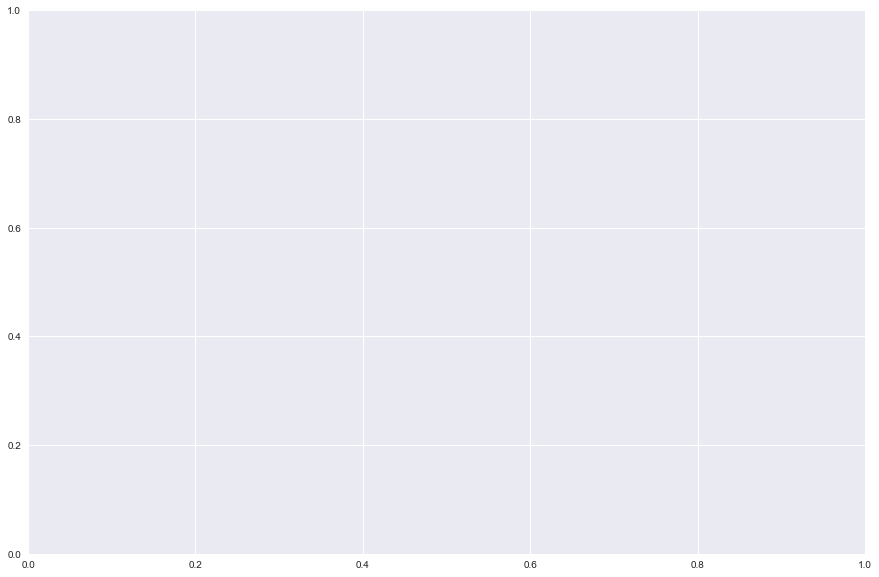

In [6]:
%matplotlib inline
exp.make_daily_rew()